In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# !pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

import random

In [ ]:
# Seeding for reproducibility, this seed may be different for different machines, we tested on heron lab machines

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
totalImages = len(trainloader.dataset)
print(totalImages)

# How many trainloaders we want to create, each with the miniAmount of images in it
miniAmount = 1000

numOfLoaders = totalImages // miniAmount

print("Number of loaders to create: " + str(numOfLoaders)) # 10 Loaders

# Contains the list of trainloaders
miniLoaders = []

for i in range(numOfLoaders):
  startIdx = i * miniAmount
  endIdx = (i + 1) * miniAmount if i < numOfLoaders - 1 else totalImages

  print("Start Index: " + str(startIdx))
  print("End Index: " + str(endIdx) + "\n")

  # Creates a subset of the whole training set
  subset = torch.utils.data.Subset(trainset, range(startIdx, endIdx))

  SubTrainLoader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  miniLoaders.append(SubTrainLoader)

50000
Number of loaders to create: 50
Start Index: 0
End Index: 1000

Start Index: 1000
End Index: 2000

Start Index: 2000
End Index: 3000

Start Index: 3000
End Index: 4000

Start Index: 4000
End Index: 5000

Start Index: 5000
End Index: 6000

Start Index: 6000
End Index: 7000

Start Index: 7000
End Index: 8000

Start Index: 8000
End Index: 9000

Start Index: 9000
End Index: 10000

Start Index: 10000
End Index: 11000

Start Index: 11000
End Index: 12000

Start Index: 12000
End Index: 13000

Start Index: 13000
End Index: 14000

Start Index: 14000
End Index: 15000

Start Index: 15000
End Index: 16000

Start Index: 16000
End Index: 17000

Start Index: 17000
End Index: 18000

Start Index: 18000
End Index: 19000

Start Index: 19000
End Index: 20000

Start Index: 20000
End Index: 21000

Start Index: 21000
End Index: 22000

Start Index: 22000
End Index: 23000

Start Index: 23000
End Index: 24000

Start Index: 24000
End Index: 25000

Start Index: 25000
End Index: 26000

Start Index: 26000
End

In [ ]:
# Testing to see how miniLoaders look

print(len(miniLoaders))

print(miniLoaders[9])

print(trainloader)

# with 5000 images in each loader, we have 10 loaders in total, need to loop back to beginning after miniLoader[9]

50


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


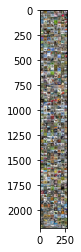

frog  frog  plane truck frog  cat   horse car   truck cat   deer  plane dog   truck car   cat   ship  horse dog   ship  deer  frog  bird  car   plane plane cat   dog   deer  car   horse car   frog  horse horse horse car   plane deer  bird  horse ship  plane ship  bird  truck plane ship  dog   truck cat   horse deer  truck car   plane dog   plane dog   horse deer  cat   deer  deer  ship  deer  dog   bird  bird  dog   bird  ship  bird  dog   deer  ship  cat   frog  bird  ship  ship  plane bird  car   frog  car   frog  bird  frog  plane horse plane ship  deer  cat   frog  car   dog   plane horse frog  cat   truck car   bird  plane car   plane horse plane dog   car   dog   truck frog  bird  dog   bird  bird  dog   ship  horse ship  deer  bird  car   plane bird  deer  horse dog   cat   deer  car   bird  car   cat   ship  dog   ship  bird  bird  frog  truck horse deer  plane cat   truck deer  frog  cat   horse car   bird  cat   cat   dog   dog   truck truck horse frog  horse deer  dog   dog 

In [ ]:
# functions to show an image for fun

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images from the first DataLoader
dataiter = iter(miniLoaders[1])
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
#based on VGG
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model=Net()

In [ ]:
PATH = ('./40_epoch_32_batch_SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

In [ ]:
finalLayer = PopModel.classifier[-1]

print(finalLayer) # 10 features out

outerShape = len(finalLayer.weight)
innerShape = len(finalLayer.weight[0])

totalWeights = outerShape * innerShape

print(outerShape) # 10 population size
print(innerShape) # 10 arrays, with 52 items in it

# 52 inputs connected to a single output, there are 10 outputs therefore 52x10 connections in total. for one output, the 52 connections will have 52 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 52 elements in each tensor, with a different set of weights.

biasCount = len(finalLayer.bias)
print(biasCount)

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 530 Parameters: 520 weights + 10 biases


Linear(in_features=52, out_features=10, bias=True)
10
52
10
530


In [ ]:
# Randomise final layer weights

nn.init.xavier_uniform(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,52)

print((finalLayer.bias).shape)

torch.Size([10, 52])
torch.Size([10])


<ipython-input-12-6e0b5b33f1e0>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [ ]:
# Additional Function for converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

In [ ]:
posMinInit      = -1
posMaxInit      = +1
VMaxInit        = 6
VMinInit        = 0.5
dimension       = paramCount
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
interval = 1
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

# Values used for the Gaussian Mutation
sigmaValue = 2.5
muValue = 0

# Standard deviation of the population should be below this number to start mutation
MutationStart = 1.0

lossTracker = []

accuracyTracker = []

In [ ]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # -1 is for minimise, 1 for maximise
creator.create("Particle", list, fitness=creator.FitnessMax, loss = list, speed=list, smin=None, smax=None, best=None)

In [ ]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]


# Euclidean Distance used for mutation
def euclideanDistance(ind1, ind2):
  distance = (ind1 - ind2)**2
  return math.sqrt(distance)

# Used to rescale distances between 0 and 1, with lower distances being scaled closer to 1.
def rescaler(distances):
  scaled = [1 / (d + 1) for d in distances]

  return scaled

In [ ]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

def assignWeights(particle):
  # First step to get the particles weights out from it, convert to an numpy array
  particleweightsNP1 = np.array(particle)

  particleweightsNP = particleweightsNP1[:totalWeights]
  biases = np.array(particleweightsNP1[-biasCount:])

  # Putting biases straight in
  biases = torch.from_numpy(biases).float()
  finalLayer.bias = torch.nn.Parameter(biases.float())

  # Converting to the correct shape!
  reshapedWeights = particleweightsNP.reshape(outerShape,innerShape)

  # Convert to torch array!
  torchWeights = torch.from_numpy(reshapedWeights).float()

  finalLayer.weight = torch.nn.Parameter(torchWeights.float())


In [ ]:
def fitnessFunction(particle, miniNumber):
    assignWeights(particle)

    total_loss = 0.0
    total_samples = 0

    correct_preds = 0
    total_preds = 0

    PopModel.to(device)

    with torch.no_grad():
        for data in miniLoaders[miniNumber]:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = PopModel(images)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Calculate the loss for all images we predict, we will average later
            total_loss = loss.item() * images.size(0)
            total_samples += images.size(0)

            # Calculate the accuracy
            for label, prediction in zip(labels, predictions):
                total_preds += 1
                if label == prediction:
                    correct_preds += 1

    average_loss = total_loss / total_samples
    acc = (correct_preds / total_preds)*100


    return (acc,), average_loss

toolbox.register("evaluate", fitnessFunction)

In [ ]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size

    fitStats = tools.Statistics(lambda ind: ind.fitness.values)
    lossStats = tools.Statistics(lambda ind: ind.loss)

    mstats = tools.MultiStatistics(fitness=fitStats, loss=lossStats)

    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - ((i-1)/(populationSize))
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = mstats.fields

    # Mutation Tick, counts the number of times the swarm std deviation is below a certain amount
    MutationTick = 0

    miniCounter = 0

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values, part.loss = toolbox.evaluate(part, miniCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best

        # sortedPop = pop

        pop.sort(key=lambda x: x.fitness, reverse=True)

        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        # Code to update particle via velocity
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval

            #logbookRecord = logbook.record(gen=g, evals=len(pop))
            logbookRecord = logbook.record(gen =g, evals = len(pop), **mstats.compile(pop))
            print(logbook.stream)

        lossPop = pop
        lossPop.sort(key=lambda x: x.loss, reverse=False)

        stDev = logbook.chapters["loss"].select("std")

        latestStd = stDev[-1]


        if latestStd < MutationStart:
          MutationTick += 1
        else:
          MutationTick = 0

        print("Current Mutation Tick: " + str(MutationTick))

        # We want to start mutation if we know the particles are starting to converge, this will be when standard deviation of the population drops below a certain value

        if MutationTick >= 5:
          print("Starting Mutation of Particles")

          # Get the best fitness value out:
          bestParticle = pop[0].loss

          # Calculate a list of euclidean distances
          distances = []

          # Loops through population apart from the first value as we dont need to calculate the distance for the first particle as it is already the best
          for i in lossPop[1:]:
            individualLosses = i.loss
            distances.append(euclideanDistance(bestParticle, individualLosses))

          # Apply a function to the distance list to map them between 0 and 1, we want the smaller EDs to have a bigger probability
          # Then apply deap mutate function to the particles with their corresponding calculated probability of mutation
          probs = rescaler(distances)

          # Iterate through both population and the probability list and mutate with the probabilities
          # Important, may need to adjust the value of sigma and mu accordingly as this is gaussian distribution

          # Larger sigma = more exploration, smaller = more exploitation
          # Mu controls the bias of the spread


          # We have the probabilities for the loss, we want to sort the actual population again by loss so we know who is who

          pop.sort(key=lambda x: x.loss, reverse=False)

          # Attempting to mutate!
          for i, p in zip(pop[1:], probs):
            tools.mutGaussian(i, mu=muValue, sigma=sigmaValue, indpb=p)

          # Reset Mutation Tick
          MutationTick = 0

        miniCounter += 1

        if miniCounter >= (len(miniLoaders)):
          miniCounter = 0
          print("Mini Counter reset!")

    return pop, logbook

if __name__ == "__main__":
    superpart = main()

                    fitness                    	                      loss                      
-----------------------------------------------	------------------------------------------------
avg    	evals	gen	max 	min	std    	avg    	evals	gen	max    	min    	std     
10.5673	153  	0  	21.3	3.4	3.23704	5.95927	153  	0  	8.55606	4.13715	0.862638
Current Mutation Tick: 1
11.1346	153  	1  	21.1	4.1	3.04653	7.16728	153  	1  	16.5414	3.49761	3.02313 
Current Mutation Tick: 0
11.8752	153  	2  	21.1	3.7	3.44323	8.19348	153  	2  	24.9416	3.38693	3.92791 
Current Mutation Tick: 0
12.6176	153  	3  	21.7	4.7	3.50872	8.50552	153  	3  	22.265 	3.20071	4.10789 
Current Mutation Tick: 0
13.7529	153  	4  	23  	5.7	3.25454	7.66143	153  	4  	23.5045	3.10849	3.46646 
Current Mutation Tick: 0
15.1908	153  	5  	25.6	6.7	3.34374	7.76324	153  	5  	25.1669	2.84505	3.93029 
Current Mutation Tick: 0
16.0144	153  	6  	23.9	7  	3.34587	7.39981	153  	6  	23.2451	2.53892	3.69565 
Current Mutation Tick: 0
17.3621

In [ ]:
# Quicksave the best particle

print(len(superpart[1]))
print(superpart[1])
arr = np.array(superpart[1])

print(arr.shape)

import csv

with open('bestPart-010.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[0][0]])

with open('bigSigmaSSPSOLogbook.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[1].chapters["fitness"].select("gen")])
    writer.writerows([superpart[1].chapters["fitness"].select("evals")])

    writer.writerows([superpart[1].chapters["fitness"].select("avg")])
    writer.writerows([superpart[1].chapters["fitness"].select("min")])
    writer.writerows([superpart[1].chapters["fitness"].select("max")])
    writer.writerows([superpart[1].chapters["fitness"].select("std")])

    writer.writerows([superpart[1].chapters["fitness"].select("gen")])
    writer.writerows([superpart[1].chapters["fitness"].select("evals")])

    writer.writerows([superpart[1].chapters["loss"].select("avg")])
    writer.writerows([superpart[1].chapters["loss"].select("min")])
    writer.writerows([superpart[1].chapters["loss"].select("max")])
    writer.writerows([superpart[1].chapters["loss"].select("std")])

100
                    fitness                    	                      loss                      
-----------------------------------------------	------------------------------------------------
avg    	evals	gen	max 	min 	std    	avg    	evals	gen	max    	min    	std     
10.5673	153  	0  	21.3	3.4 	3.23704	5.95927	153  	0  	8.55606	4.13715	0.862638
11.1346	153  	1  	21.1	4.1 	3.04653	7.16728	153  	1  	16.5414	3.49761	3.02313 
11.8752	153  	2  	21.1	3.7 	3.44323	8.19348	153  	2  	24.9416	3.38693	3.92791 
12.6176	153  	3  	21.7	4.7 	3.50872	8.50552	153  	3  	22.265 	3.20071	4.10789 
13.7529	153  	4  	23  	5.7 	3.25454	7.66143	153  	4  	23.5045	3.10849	3.46646 
15.1908	153  	5  	25.6	6.7 	3.34374	7.76324	153  	5  	25.1669	2.84505	3.93029 
16.0144	153  	6  	23.9	7   	3.34587	7.39981	153  	6  	23.2451	2.53892	3.69565 
17.3621	153  	7  	28.9	8.2 	3.28936	6.96777	153  	7  	21.8246	2.48934	3.01232 
18.9824	153  	8  	29.3	8.9 	3.36891	7.08275	153  	8  	20.2757	2.23955	3.27126 
19.5471	153 

In [ ]:
# Write accuracy data to csv

with open('lossTrack-010.csv', 'a', newline='') as file:
    newWriter = csv.writer(file)
    newWriter.writerows([lossTracker])

In [ ]:
def testEvaluate(bestParticle):
    assignWeights(bestParticle)

    correct = 0
    total = 0

    PopModel.to(device)

    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = PopModel(images)

        _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct += 1
        total += 1

    testAcc = (correct/total)*100

    print(f'Best Particle Accuracy on Test Set: {testAcc}%')

    return testAcc

In [ ]:
accFinal = testEvaluate(superpart[0][0])

Best Particle Accuracy on Test Set: 50.73529411764706%


In [ ]:
f = open("testAccuracy-010.txt", "a")
f.write(str(accFinal))
f.close()